In [11]:
%matplotlib inline


# Training a neural operator on Darcy-Flow
In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package


In [12]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

Loading the Navier-Stokes dataset in 128x128 resolution



In [13]:
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32


We create a tensorized FNO model



In [14]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 389697 parameters.


Create the optimizer



In [15]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Creating the losses



In [16]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [17]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (convs): FactorizedSpectralConv(
    (weight): ModuleList(
      (0-7): 8 x ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
    )
  )
  (fno_skips): ModuleList(
    (0-3): 4 x SoftGating()
  )
  (lifting): Lifting(
    (fc): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (projection): Projection(
    (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (fc2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.training.losses.H1Loss object at 0x7f61ee4c4d00>

 * Test: {'h1': <neuralop.training.losses.H1Loss object at 0x7f61ee4c4d00>, 'l2': <neuralop.training.losses.LpLoss object at 0x7f61ee4c4be0>}


Create the trainer



In [18]:
trainer = Trainer(model, n_epochs=100,
                  device=device,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

Training on regular inputs (no multi-grid patching).


Actually train the model on small Darcy-Flow dataset



In [19]:
trainer.train(train_loader, test_loaders,
              output_encoder,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
[0] time=1.71, avg_loss=4.9964, train_err=0.4996, 16_h1=0.3662, 16_l2=0.2800, 32_h1=0.4451, 32_l2=0.2773
[3] time=1.71, avg_loss=2.3184, train_err=0.2318, 16_h1=0.2826, 16_l2=0.2196, 32_h1=0.3585, 32_l2=0.2309
[6] time=1.69, avg_loss=1.8638, train_err=0.1864, 16_h1=0.2289, 16_l2=0.1893, 32_h1=0.3338, 32_l2=0.2148
[9] time=1.71, avg_loss=1.6579, train_err=0.1658, 16_h1=0.1669, 16_l2=0.1206, 32_h1=0.2667, 32_l2=0.1267
[12] time=1.73, avg_loss=1.6425, train_err=0.1643, 16_h1=0.1523, 16_l2=0.1101, 32_h1=0.2549, 32_l2=0.1279
[15] time=1.81, avg_loss=1.4818, train_err=0.1482, 16_h1=0.1807, 16_l2=0.1454, 32_h1=0.2694, 32_l2=0.1636
[18] time=1.76, avg_loss=1.3579, train_err=0.1358, 16_h1=0.1357, 16_l2=0.0924, 32_h1=0.2419, 32_l2=0.1084
[21] time=1.97, avg_loss=1.2949, train_err=0.1295, 16_h1=0.1301, 16_l2=0.0875, 32_h1=0.2462, 32_l2=0.1172
[24] time=1.72, avg_loss=1.2559, train_err=0.1256, 16_h1=0.1279, 16_l2

Plot the prediction, and compare with the ground-truth 
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



/tmp/ipykernel_7035/1837442807.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


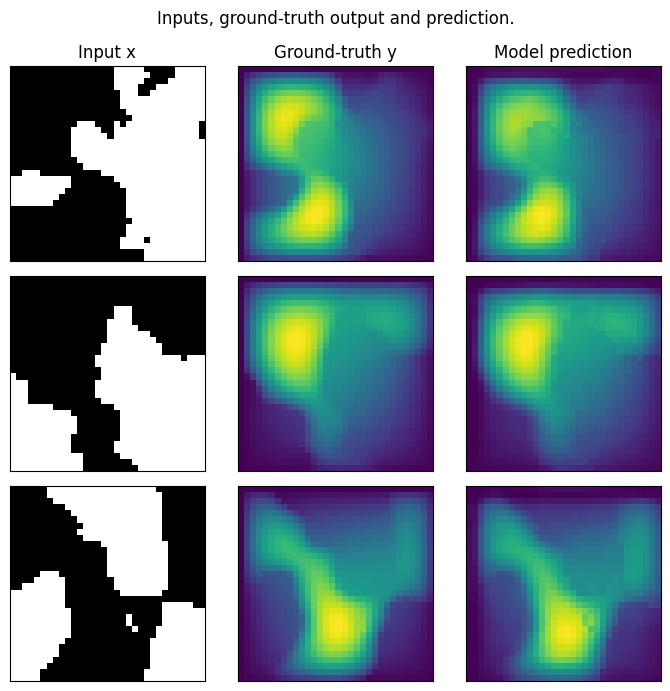

In [20]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()